SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #6: Using Exogenuos Veriables in ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - exogenious variables, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityMACAPE, qualityRMSE
import warnings
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# ARIMA Parameters
**Questions**
  * How to make TS stationary?
  * Write down formula that describes how the tranformed ts will look like (use lag operator $\bf B$).

**Answer**
$${\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)$$
where $s~-$ seasonality period


 




## ARIMA model for non-stationary time series
In order to make ts stationary we apply trend ${\bf(1-\bf B)}$ differencing $d$ times and seasonal ${\bf(1-B^s)}$ differencing $D$ times.


**Main hypothesys**: exists $d$, $D$, $\lambda$ such that
  
  * $$ {\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)~- \text{ stationary} $$ 


Final ts model:
* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}z_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iz_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}(z_t-\mu) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Fitting Parameters of ARIMA model

Classic form of ARIMA model implies that there are some seasonal Autoregressive Components and seasonal Moving Average Components


$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}z_t = \underbrace{c+\sum_{i=1}^{\color{red}p} \alpha_iz_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\underbrace{\sum_{l=1}^{\color{red}P} \delta_lz_{t-\color{red}{s\cdot l}}}\limits_{seasonal~AR}+\underbrace{\sum_{m=1}^{\color{red}Q} \omega_m\varepsilon_{t-\color{red}{s*m}}}\limits_{seasonal~MA}+\varepsilon_t$$


Classic ARIMA model contains 6 (hyper)parameters:
$$ARIMA(p, d, q)\times(P, D, Q)_s$$
where

 - $p~-$ is a number of non-seasonal AR components
 - $q~-$ is a number of non-seasonal MA components
 - $d~-$ is a number of trend-differencing applied to make ts stationary
 - $P~-$ is a number of seasonal AR components
 - $Q~-$ is a number of seasonal MA components
 - $D~-$ is a number of seasonal-differencing to make ts stationary

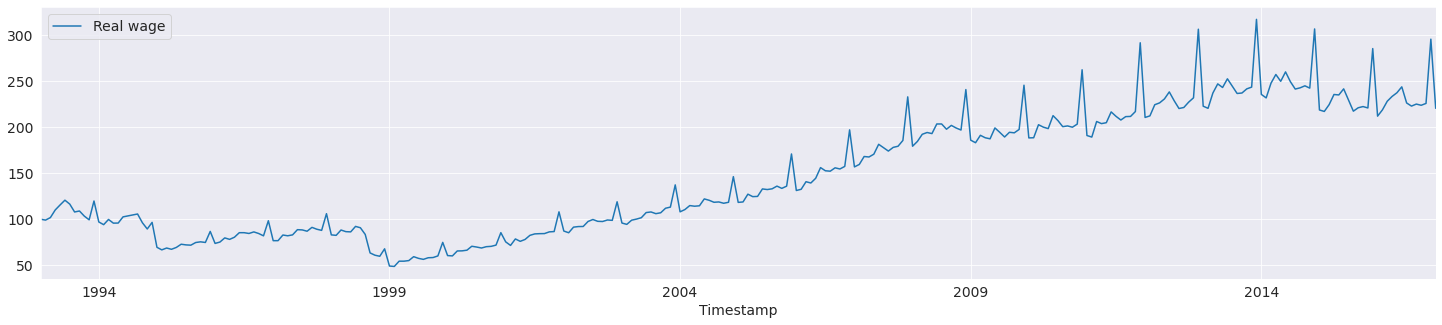

In [ ]:
# Wage
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
ts_wage.plot()

## Fitting of $\lambda$, $d$, $D$ parameters

optimal lambda: 0.12682613030318318
The KPSS test statistic 0.031104, 
pvalue: 0.10 
maximal Lag: 16 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The Augmented Dickey-Fuller test statistic -4.434243, 
pvalue: 0.00 
maximal Lag: 15 
critical values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


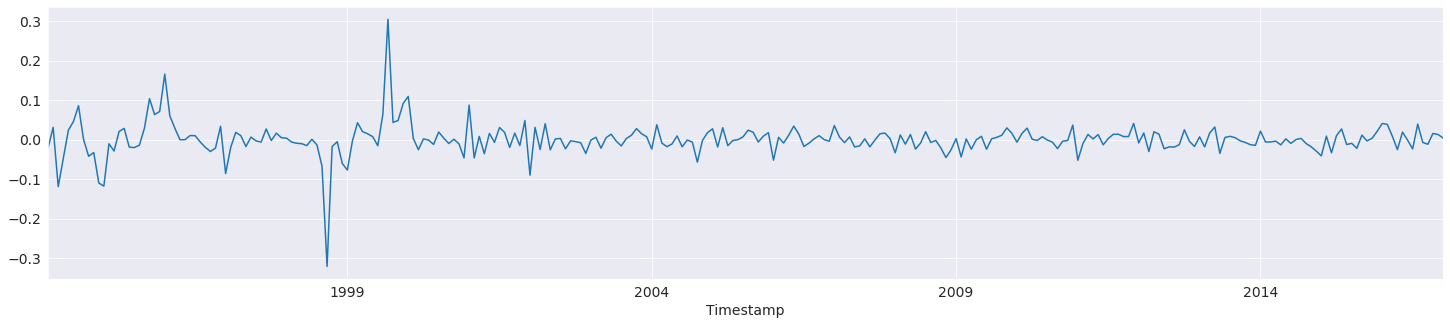

In [ ]:
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage['Real wage'])[1])

# Box_Cox transformation (see lesson 4 for details)
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
# ts_wage_boxcox['wage_boxcox'].plot()


# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
# sdiff_ts_wage_boxcox.plot()

# trend differencing
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot()

# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))


In [ ]:
# Let's train our first ARMA(p,q) model
arma_mod00 = sm.tsa.ARMA(diff_sdiff_ts_wage_boxcox, (0,0)).fit()
print(arma_mod00.summary())
# print(arma_mod00.aic, arma_mod00.bic, arma_mod00.hqic)


                              ARMA Model Results                              
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                     ARMA(0, 0)   Log Likelihood                 490.277
Method:                           css   S.D. of innovations              0.041
Date:                Sat, 02 Oct 2021   AIC                           -976.554
Time:                        11:38:59   BIC                           -969.313
Sample:                    02-01-1994   HQIC                          -973.648
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.103      0.918      -0.005       0.005


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


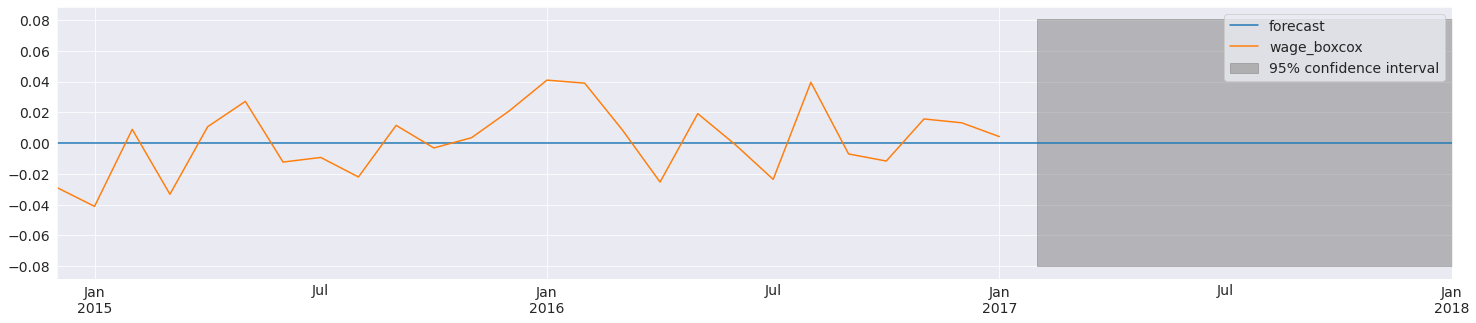

In [ ]:
frc_arma = arma_mod00.predict('2014-12-01', '2017-12-01', dynamic=False)
# fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arma_mod00.plot_predict(start='2014-12-01', end='2018-01-01')
# print(frc_arma)

**Questions**
  * What should be done to forecast original wage ts?

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 490.272
Date:                            Sat, 02 Oct 2021   AIC                           -978.543
Time:                                    11:43:11   BIC                           -974.923
Sample:                                01-01-1993   HQIC                          -977.090
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017   3.91e-05     42.883      0.000       0.002       0.002
Ljung-Box (Q):                     

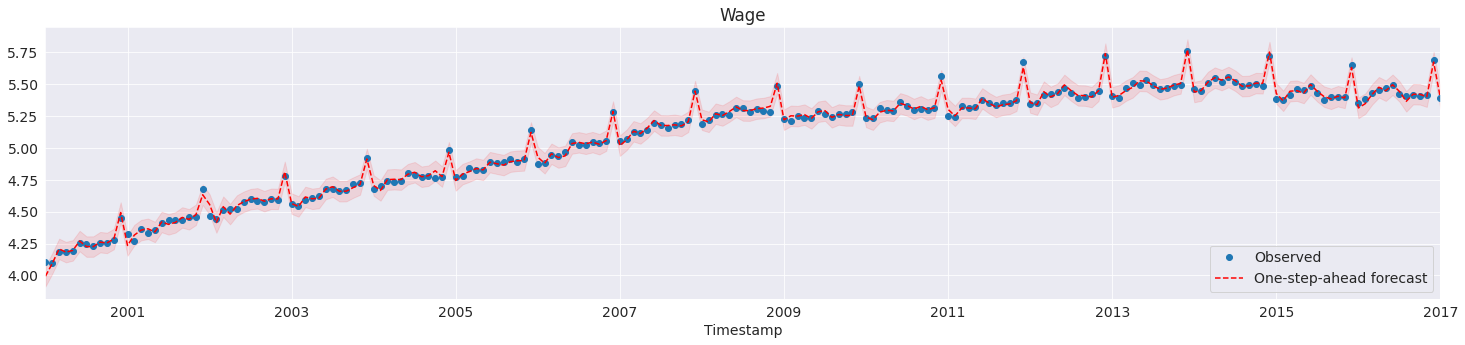

In [ ]:
# Let's train our first ARIMA (p, d, q)x(P, D, Q, s) model
arima_010_010 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 0), seasonal_order = (0,1,0,12)).fit()
print(arima_010_010.summary())


predict = arima_010_010.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2000-01-01'

#  Dynamic predictions
# predict_dy = arima_010_010.get_prediction(dynamic=start_dt)
# predict_dy_ci = predict_dy.conf_int() # confidence interval

# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Wage', xlabel='Date')

# Plot data points
ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_dt:]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc[start_dt:].plot(ax=ax, style='g', label='Dynamic forecast 2014-01')
# ci = predict_dy_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')

## Fitting of $q$, $Q$ and $p$, $P$ parameters

  
**Autocorrelation coeficient:**
*  $$ r_\tau = r_{y_t y_{t+\tau}} = \frac{\sum\limits_{t=1}^{T-\tau} \left(y_t - \bar{y}\right)\left(y_{t+\tau} - \bar{y}\right) }{ \sum\limits_{t=1}^T \left(y_t - \bar{y}\right)^2 },\;\; \bar{y} = \frac1{T} \sum_{t=1}^T y_t.$$
		
$r_\tau \in\left[-1,1\right], \;\; \tau$ - autocorrelation lag.




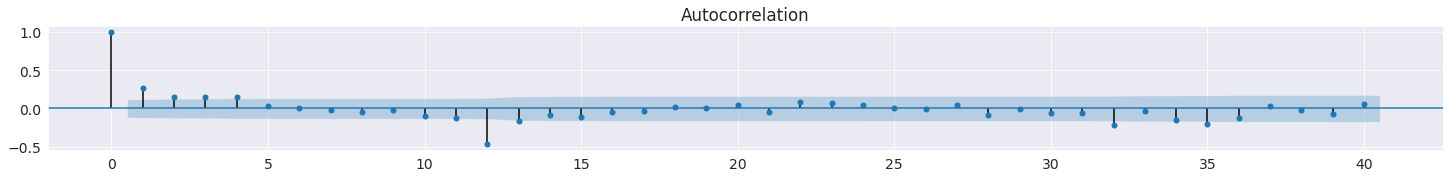

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)

**Coefficient of partial correlation:** between $y$, $x_1$ excluding dependence on $x_2$:
<img src='https://github.com/aromanenko/ATSF/blob/main/pic/PACF.PNG?raw=1'>

* <font color="red">Coefficient of partial correlation</font> shows correlation between $y_t$ and $y_{t+\tau}$, <font color=""> excluding dependence </font>
   - between $y_t$ and $y_{t+1}$ ($y_{t+\tau}$ and $y_{t+1}$)  
   - between $y_t$ and $y_{t+2}$ ($y_{t+\tau}$ and $y_{t+2}$)
   
   ...
   
   - between $y_t$ and $y_{t+\tau-1}$ ($y_{t+\tau}$ and $y_{t+\tau-1}$)


*  see here  <a href="https://timeseriesreasoning.com/contents/partial-auto-correlation"> here </a> for details

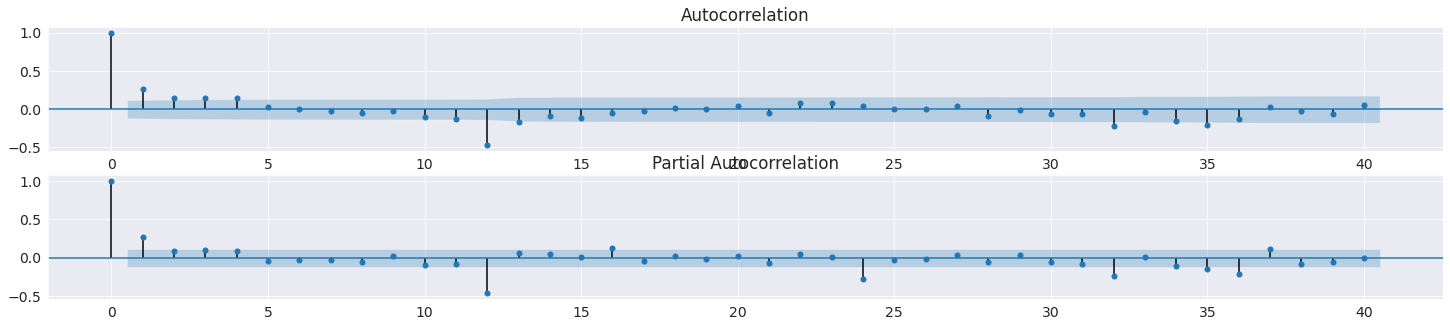

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox, lags=40, ax=ax2)

**How to select candidates for $q$ and $Q$ based on ACF?**

*Answer*: 
* $q$: the number of the last lag $\tau<S$ at which <span style="color:red"> ACF </span> was significant ($S$ - period of seasonality)
* $Q$: the lag numbers $\tau= s*m$ that are multiples of the seasonality period $s$: at which <span style="color:red"> ACF </span> was significant

**How to select candidates for $p$ and $P$ based on PACF?**

*Answer*: 

* $p$: the number of the last lag $\tau<S$ at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant
* $P$: he lag numbers $\tau= s*m$ that are multiples of the seasonality period at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant


**Question**:
* Provide candidates for $q, Q, p, P$ values in case of the wage_ts 
  * $q$ = {1, 2, 3, 4}
  * $Q$ = {1}
  * $p$ = {1}
  * $P$ = {1, 2, 3}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                     ARMA(1, 1)   Log Likelihood                 502.552
Method:                       css-mle   S.D. of innovations              0.039
Date:                Sat, 02 Oct 2021   AIC                           -997.104
Time:                        11:48:45   BIC                           -982.622
Sample:                    02-01-1994   HQIC                          -991.293
                         - 01-01-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0002      0.004      0.050      0.960      -0.008       0.008
ar.L1.wage_boxcox     0.6798      0.123      5.509      0.000       0.438       0.922
ma.L1.wage_boxcox    -0.

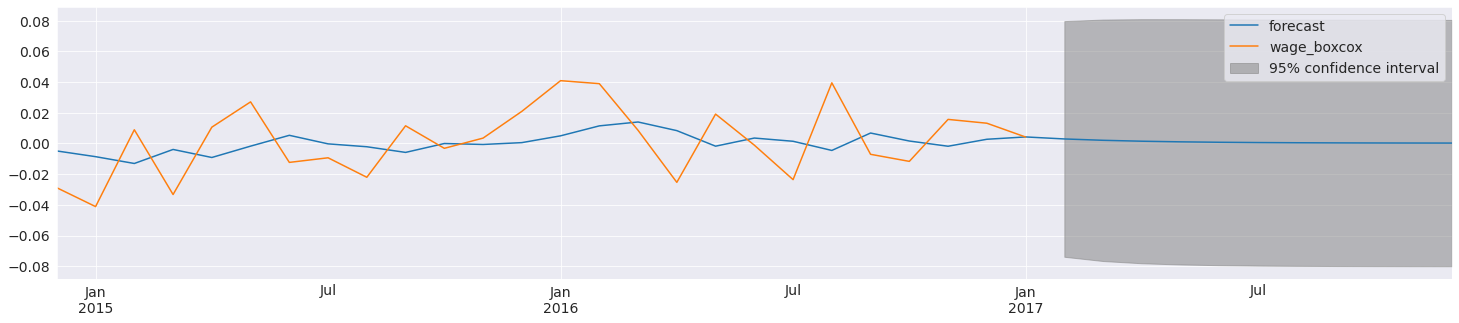

In [ ]:
# Let's train the second ARMA model
arma_mod11 = sm.tsa.ARMA(diff_sdiff_ts_wage_boxcox, (1,1)).fit()
print(arma_mod11.summary())
frc_arma = arma_mod11.predict('2014-12-01', '2017-12-01', dynamic=False)
fig, ax = plt.subplots()
fig = arma_mod11.plot_predict(start='2014-12-01', end='2017-12-01', ax=ax)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 555.495
Date:                            Sat, 02 Oct 2021   AIC                          -1098.991
Time:                                    11:51:00   BIC                          -1077.268
Sample:                                01-01-1993   HQIC                         -1090.274
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1678      0.049      3.427      0.001       0.072       0.264
ar.S.L12      -0.3036      0.182   

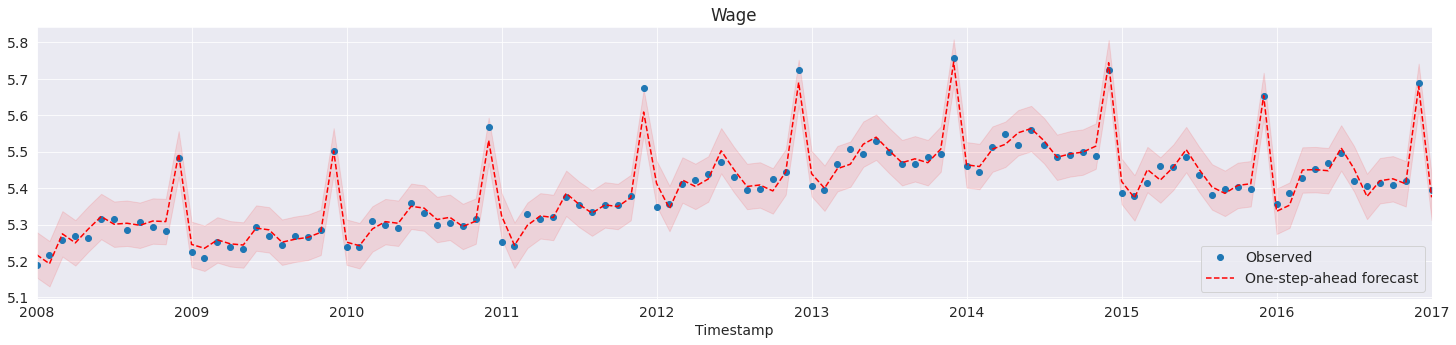

In [ ]:
# Let's train the second ARIMA(p,d,q)x(P, D, Q) model 
arima_011_311 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 1), seasonal_order = (3,1,1,12)).fit()
print(arima_011_311.summary())


predict = arima_011_311.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2008-01-01'

#  Dynamic predictions
# predict_dy = arima_010_010.get_prediction(dynamic=start_dt)
# predict_dy_ci = predict_dy.conf_int() # confidence interval

# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Wage', xlabel='Date')

# Plot data points
ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_dt:]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc[start_dt:].plot(ax=ax, style='g', label='Dynamic forecast 2014-01')
# ci = predict_dy_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')

**What else can be done?**
## Residuals Analysis


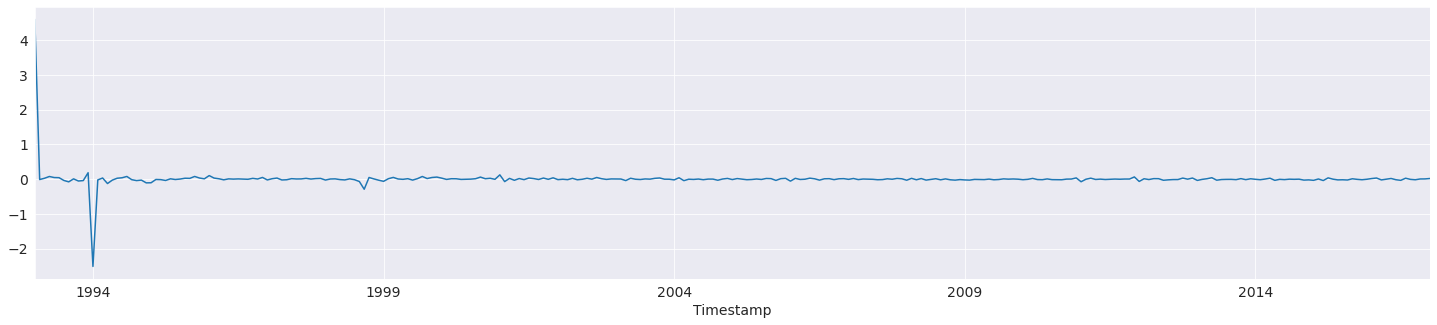

In [ ]:
# plot residuals
fig = plt.figure()
ax = fig.add_subplot(111)
ax = arima_011_311.resid.plot(ax=ax);

### Autocorrelation test

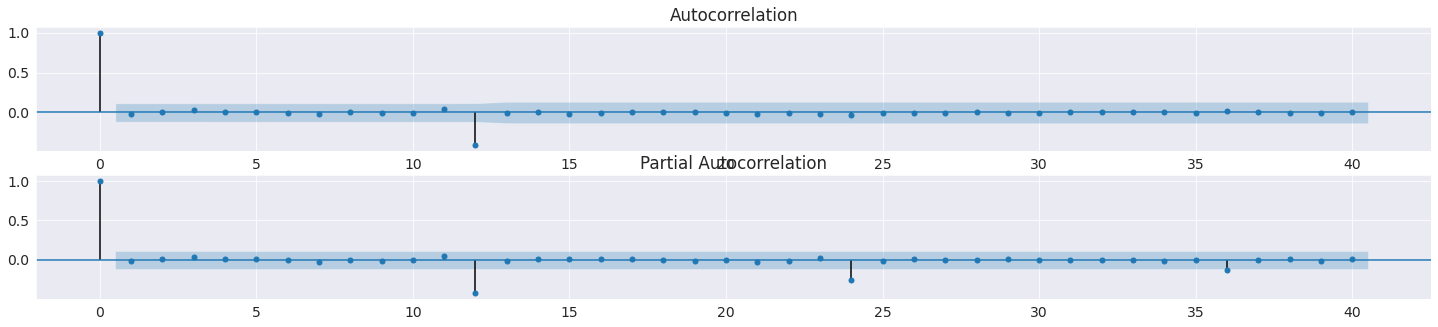

In [ ]:
# Autocorrelation analysis of residuals
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_011_311.resid.values, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_011_311.resid.values, lags=40, ax=ax2)

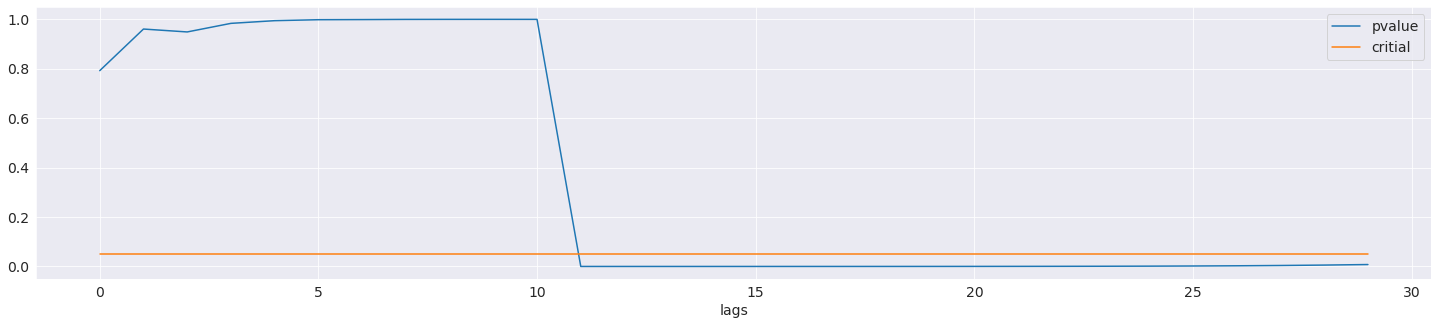

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_011_311.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot()

It seems that LL lags for $\tau>12$ are correlated

# ARMA for forecasing Retail Time Series

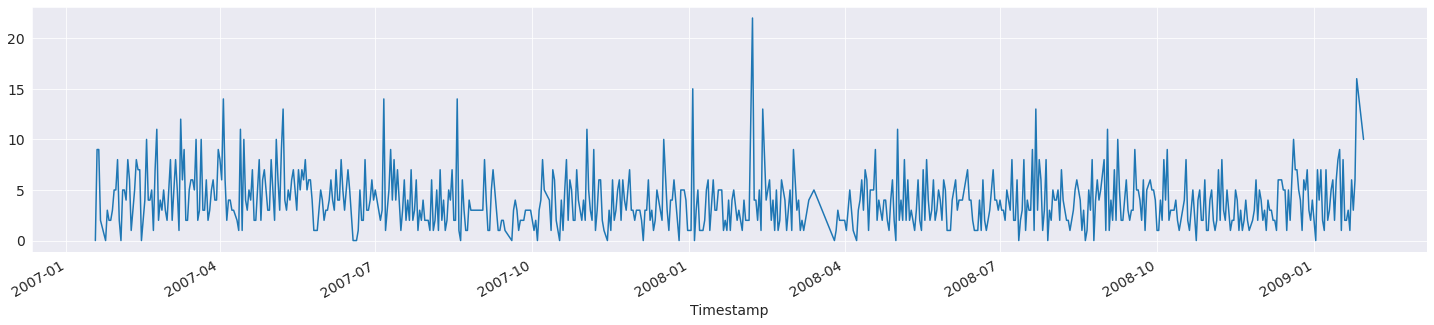

In [ ]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
# ts.head()
dta = ts[ts.columns[0]].dropna()
dta.plot()

It can be assumed that TS is stationary

**Question**
   * Select candidates for $p$ and $q$ values for ARMA model

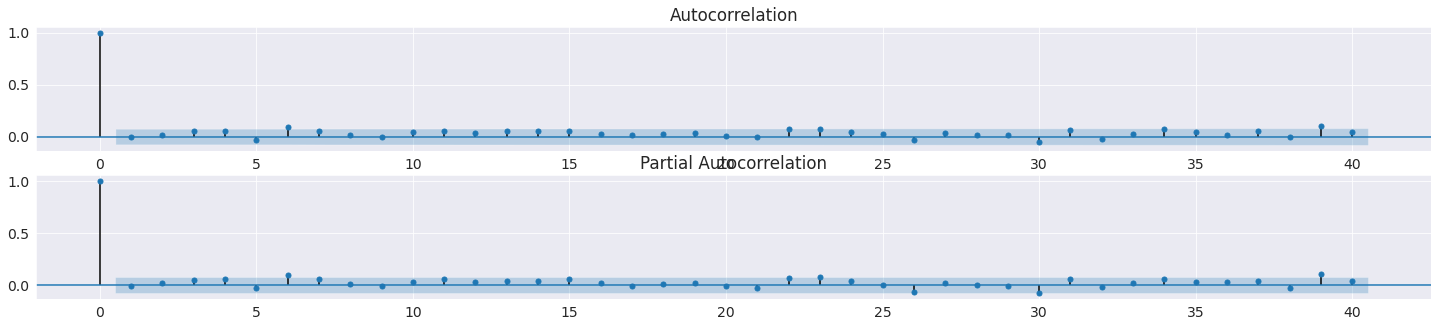

In [ ]:
# Use Item 165
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

Let's try 
* $q$ = {0, 6}
* $p$ = {0, 6}

In [ ]:
# ARMA (p=0, q=0)
arma_mod00 = sm.tsa.ARMA(dta, (0,0)).fit()
print(arma_mod00.params)
print(arma_mod00.llf,arma_mod00.aic, arma_mod00.bic, arma_mod00.hqic)

const    3.910819
dtype: float64
-1647.8191313253349 3299.6382626506697 3308.694178485915 3303.142639335463


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# ARMA (p=0, q=6)
arma_mod06 = sm.tsa.ARMA(dta, (0,6)).fit()
print(arma_mod06.params)
print(arma_mod06.llf, arma_mod06.aic, arma_mod06.bic, arma_mod06.hqic)

const               3.916494
ma.L1.Item:  165   -0.014762
ma.L2.Item:  165    0.019738
ma.L3.Item:  165    0.050564
ma.L4.Item:  165    0.044455
ma.L5.Item:  165   -0.038893
ma.L6.Item:  165    0.099277
dtype: float64
-1642.3704844195888 3300.7409688391776 3336.964632180158 3314.7584755783523


In [ ]:
# ARMA (p=6, q=0)
arma_mod60 = sm.tsa.ARMA(dta, (6,0)).fit()
print(arma_mod60.params)
print(arma_mod60.llf, arma_mod60.aic, arma_mod60.bic, arma_mod60.hqic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


const               3.917924
ar.L1.Item:  165   -0.006394
ar.L2.Item:  165    0.014409
ar.L3.Item:  165    0.050951
ar.L4.Item:  165    0.058122
ar.L5.Item:  165   -0.031947
ar.L6.Item:  165    0.094291
dtype: float64
-1642.204847043037 3300.409694086074 3336.6333574270543 3314.4272008252487


In [ ]:
# ARMA (p=6, q=6)
arma_mod66 = sm.tsa.ARMA(dta, (6,6)).fit()
print(arma_mod66.params)
print(arma_mod66.llf, arma_mod66.aic, arma_mod66.bic, arma_mod66.hqic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

### Analyse Residuals to proof the model

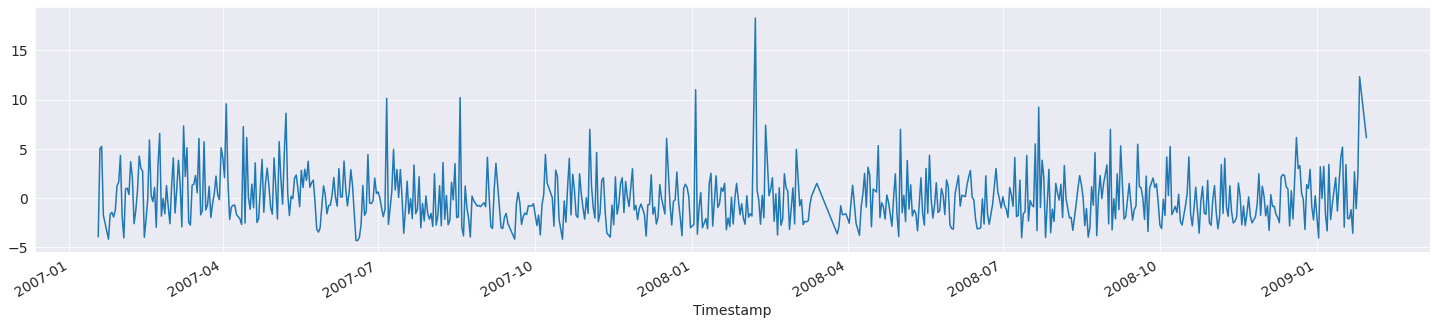

In [ ]:
# plot residuals
arma_mod06.resid.plot();

### Stationarity test

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arma_mod06.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.475620, 
pvalue: 0.05 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


It can be assumed that TS is stationary

### Autocorrelation test

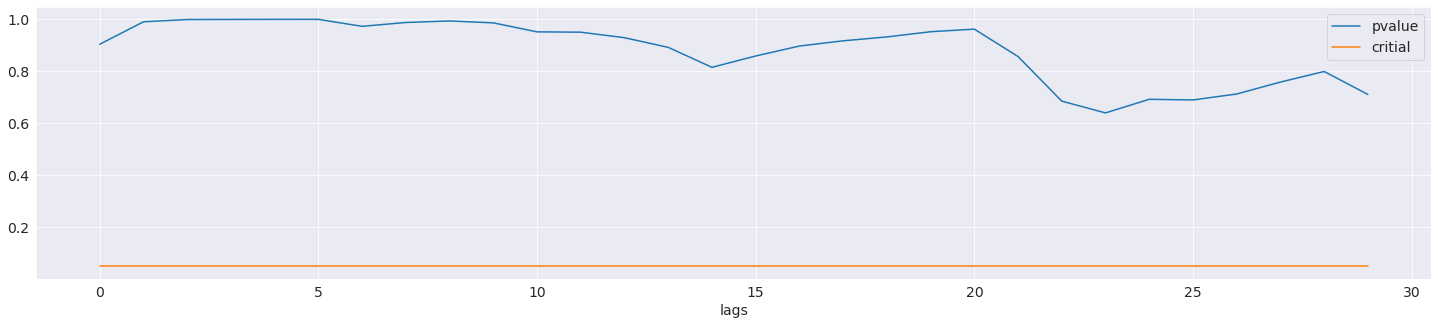

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arma_mod06.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot()
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Values of the residuals TS are not correlated

### Unbiasedness test

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arma_mod06.resid.values)

1.9799781123277063

In [ ]:
# Wilcoxon test
stat, p = stats.wilcoxon(arma_mod06.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 104567.000000
pvalue: 0.02


Residuals are biased!

### Normality test

In [ ]:
stats.normaltest(arma_mod06.resid)

NormaltestResult(statistic=211.5149831946803, pvalue=1.1751815900585055e-46)

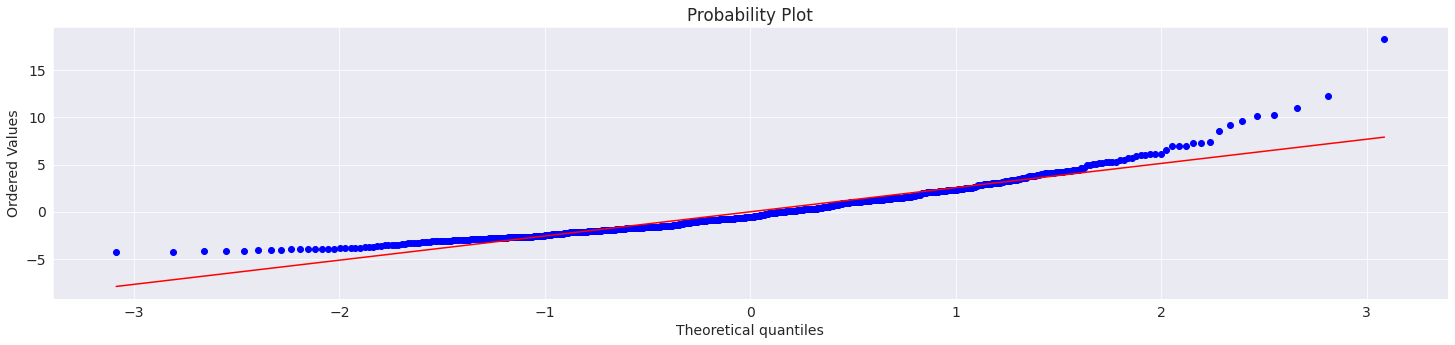

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arma_mod06.resid, dist="norm", plot = plt)

* Hypothesis of normality can be rejected because of heavy tails of the real distribution 

### Forecast of Validation Period (in-sample)
Despite of theoretical issues of the built model we can generate forecast for the time series


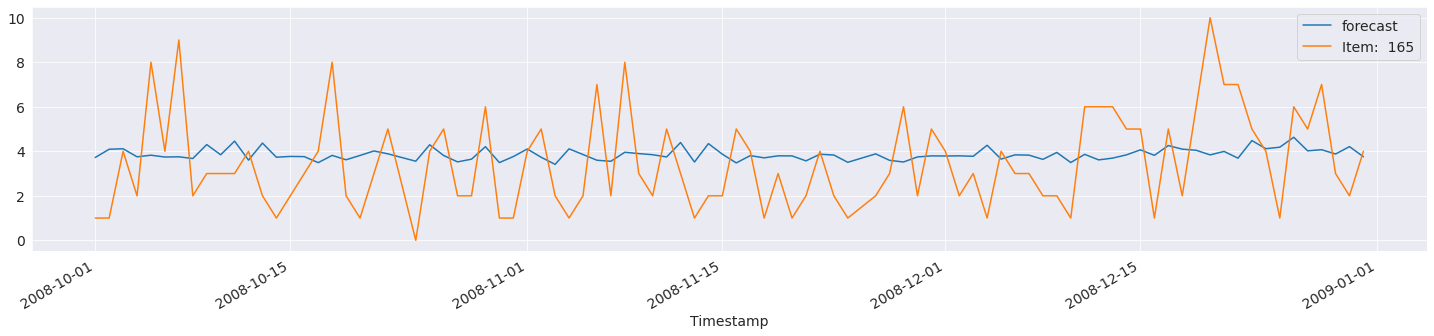

In [ ]:
# Static forecasting = one-step-ahead
fig, ax = plt.subplots()
fig = arma_mod06.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax, dynamic=False)
# frc_arma = arma_mod06.predict('2008-12-30', '2008-12-31', dynamic=False)
# print(frc_arma)

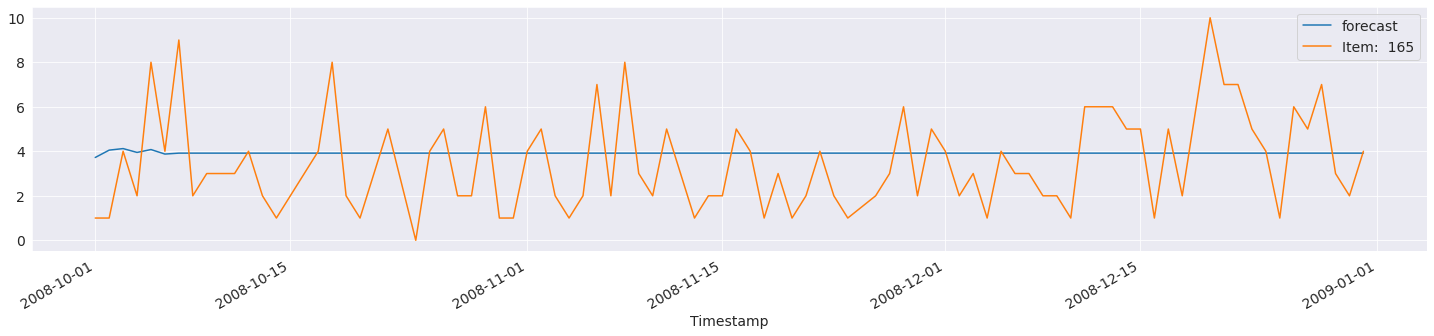

In [ ]:
# Dynamic forecasting = n-step-ahead
fig, ax = plt.subplots()
fig = arma_mod06.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax, dynamic=True)
# print(frc_arma)

### Forecast of Future Period (out-of-sample)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


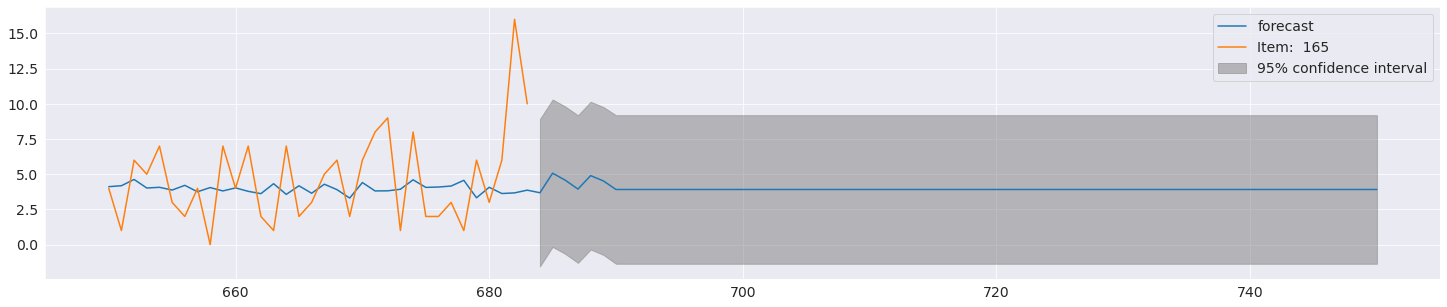

In [ ]:
# fig, ax = plt.subplots(figsize=(25,5),  linewidth=3.0)
fig = arma_mod06.plot_predict(650, 750)
# frc_arma = arma_mod06.forecast(steps=85)
# print(frc_arma[1])

# ACF anf PACF of ARIMA models



Example1 : ACF and PACF for AR(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR1.PNG?raw=1'>

Example2 : ACF and PACF for AR(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR2.PNG?raw=1'>


Example3 : ACF and PACF for AR(1) and MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/ARMA_1_1.PNG?raw=1'>



Example4 : ACF and PACF for MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_1.PNG?raw=1'>

<!-- 
Example5 : ACF and PACF for MA(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_2.PNG?raw=1'> -->

# Using exogenous variables in ARIMA models

## Energy Consumption

In [3]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
en_ts =pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/energy_consump.csv', decimal='.', parse_dates=['Date'], dayfirst=False, index_col='Date')
en_ts.index.names=['Timestamp']

# Working only Hub=Center and ZSP=FZSZOE27
energy_ts= en_ts[(en_ts['ZSP']=='FZSZOE27') & (en_ts['Hub']=='Center')]
# energy_ts.tail()

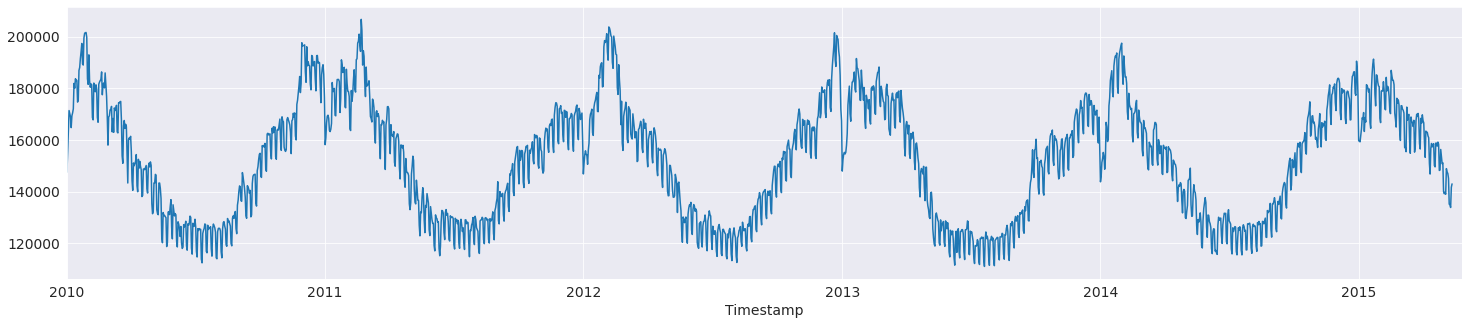

In [4]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot()

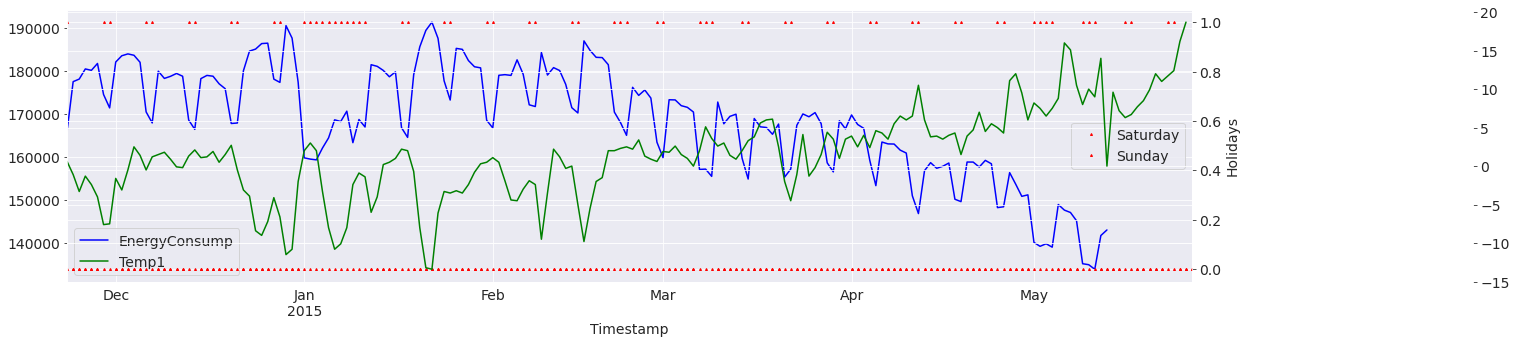

In [5]:
# See dependence on other varibales
fig, ax = plt.subplots()
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

In [ ]:
# Stationary test
kpss_stat= stattools.kpss(energy_ts['EnergyConsump'])
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic nan, 
pvalue: nan 
maximal Lag: 26 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


<!-- ## (Optional) Check the  TS and exogenios variables -->

In [ ]:
energy_ts['EnergyConsump'].values.squeeze()

array([147487.171, 155433.8  , 164140.232, ...,        nan,        nan,
              nan])

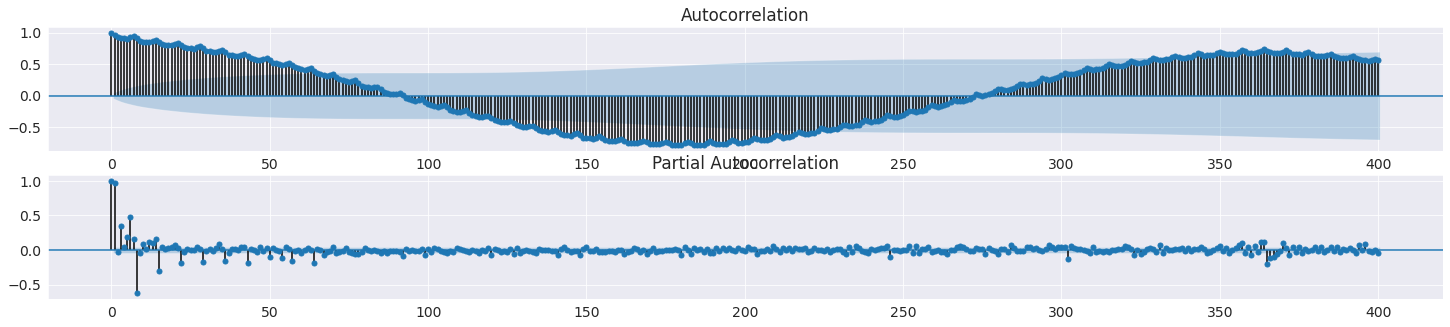

In [ ]:
# ACF and PACF
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax2)

**Question**
 - Can we use thiss ACF, PACF for choosing p,q?

## Fitting of $\lambda, d, D$ parameters

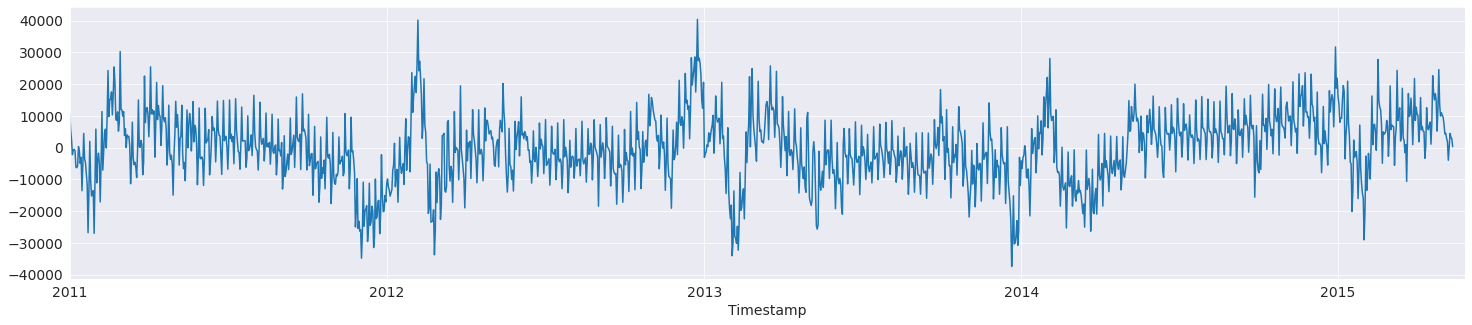

In [ ]:
# Differencing
s = 365
shift365_energy = (energy_ts[['EnergyConsump']] - energy_ts[['EnergyConsump']].shift(s))[s:]
shift365_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

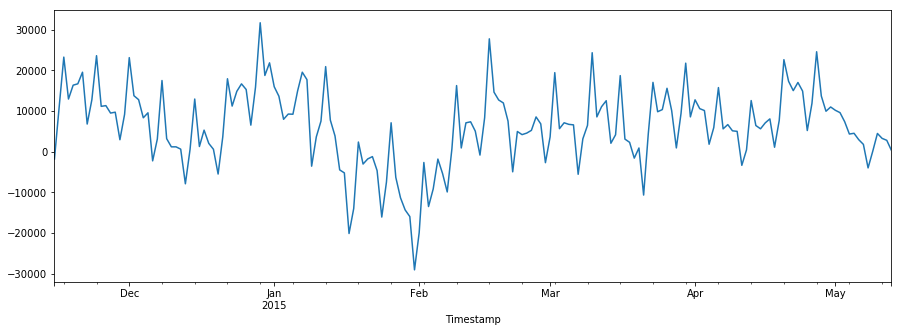

In [ ]:
shift365_energy['EnergyConsump'].tail(180).plot(figsize=(15,5))

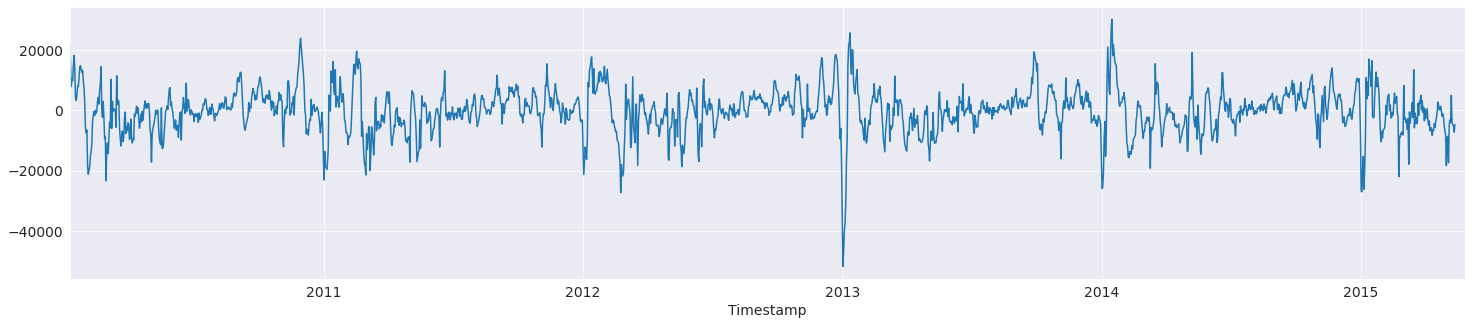

In [ ]:
s=7
dif7_energy = (energy_ts[['EnergyConsump']] - energy_ts[['EnergyConsump']].shift(s))[s:]
dif7_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

In [ ]:
# Stationary test
kpss_stat= stattools.kpss(np.array(dif7_shift365_energy['EnergyConsump']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.009940, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



* It seems that TS is stationary
** Question: ** 
  * Are TS for exogenious variables stationary?

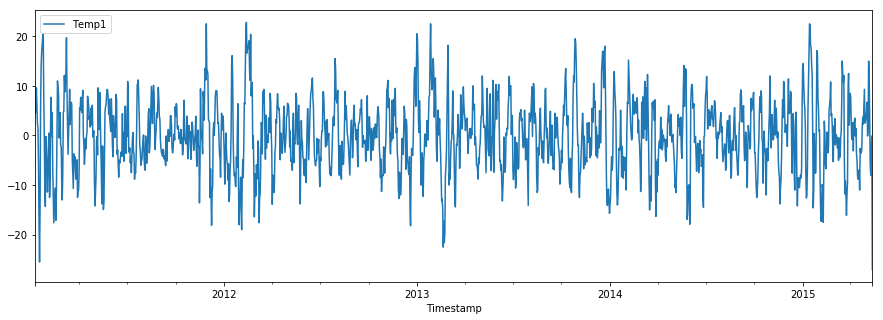

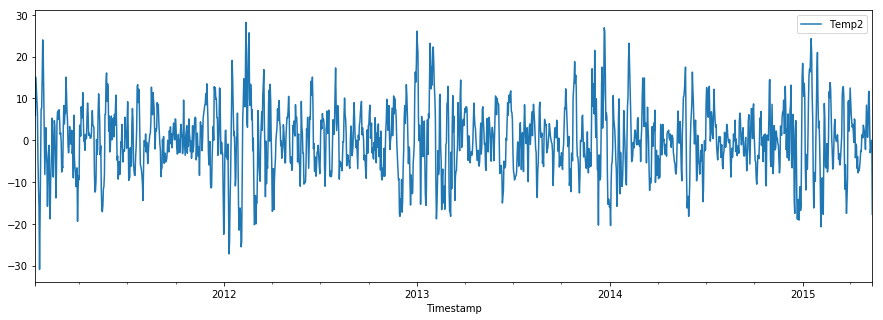

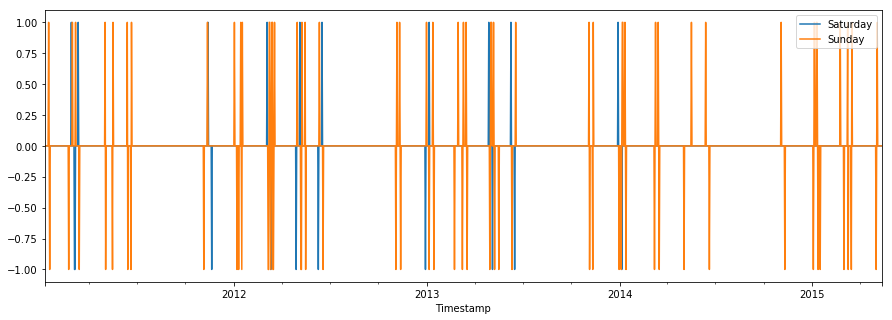

In [ ]:
# plot grap for the individual variables
dif7_shift365_energy[['Temp1']].plot(figsize=(15,5))
dif7_shift365_energy[['Temp2']].plot(figsize=(15,5))
dif7_shift365_energy[['Saturday', 'Sunday']].plot(figsize=(15,5))

In [ ]:
# TODO: build KPSS test for all exog variables
kpss_stat= stattools.kpss(np.array(dif7_shift365_energy['Temp1']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.008394, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



## Use only exogenious variables to forecast TS

In [ ]:
# apply regression for defferenced TS
exogs = energy_ts[['Temp1', 'Temp2', 'Saturday','Sunday']][dif7_shift365_energy.index<'2015-05-01']
extra_exogs = dif7_shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = dif7_shift365_energy[['EnergyConsump']][dif7_shift365_energy.index<'2015-05-01']

In [ ]:
# Only regressors
arima_mod000 = sm.tsa.ARIMA(ts, (0,0,0), exog=exogs).fit()
print(arima_mod000.params)
print(arima_mod000.aic, arima_mod000.bic, arima_mod000.hqic)

const          36.114920
Temp1        -455.754651
Temp2         -94.747830
Saturday    -8821.376321
Sunday     -10395.544799
dtype: float64
32194.2320784 32226.4003309 32206.1870399


A suitable model  $ARMA(p1,q1)$ for residuals of regression  $z_t$  is selected 
**Caution: we forget seasonality **

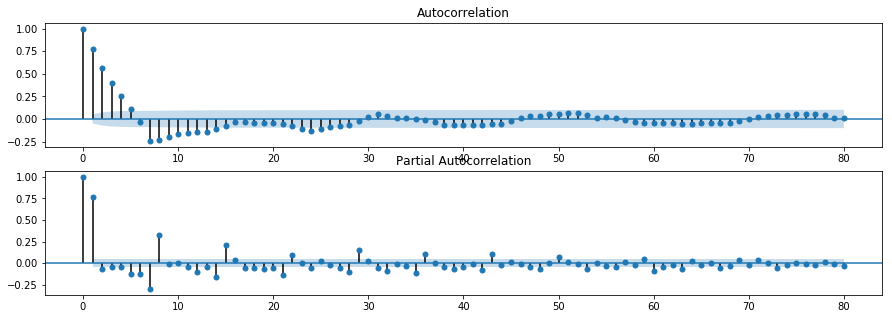

In [ ]:
# acf for difference TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=80, ax=ax2)

** Question:**
   * What are candidates for p and q?
       - candidates values for p - 1 
       - candidates values for q - 7 

* Regression is rebuilt in supposition that the errors are described by model ARMA(p1,q1)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



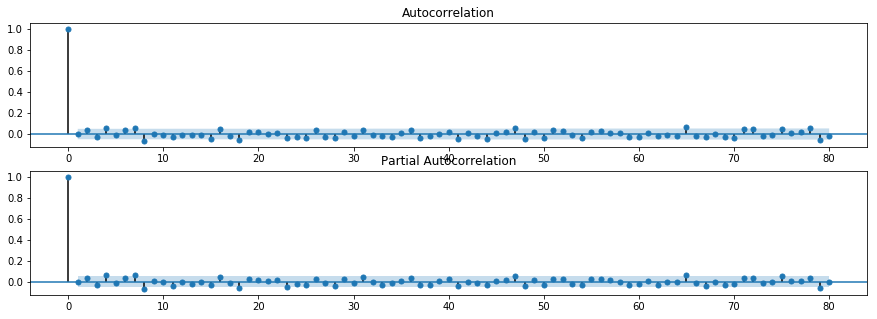

In [ ]:
arima_mod107 = sm.tsa.ARIMA(ts, (1,0,7), exog=exogs).fit()
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107.resid.values.squeeze(), lags=80, ax=ax2)

* Is seems  there is no more lags to take into account
* Let's analyse resudials

### Residuals $\varepsilon_t$  are analyzed.

### Stationarity

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod107.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.281045, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



* Residuals are stationary

### Autocorrelation test

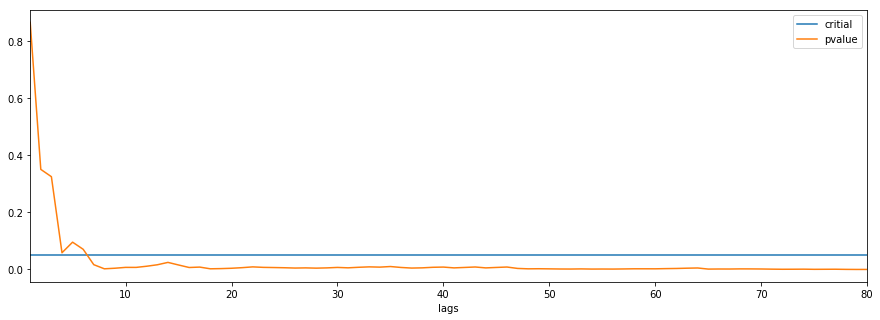

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod107.resid.values, lags=80)[1], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

### Unbiasedness test

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod107.resid.values)

1.9894606433277848

Residuals are not biased!

### Normality test

In [ ]:
stats.normaltest(arima_mod107.resid)

NormaltestResult(statistic=117.77930740670955, pvalue=2.6579594769708018e-26)

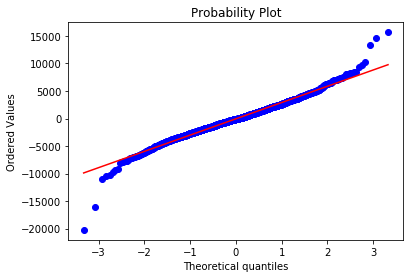

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arima_mod107.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

In [ ]:
print(arima_mod107.summary())

                              ARMA Model Results                              
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                     ARMA(1, 7)   Log Likelihood              -14814.580
Method:                       css-mle   S.D. of innovations           2943.728
Date:                Sun, 24 Sep 2017   AIC                          29657.160
Time:                        19:21:47   BIC                          29732.219
Sample:                    01-08-2011   HQIC                         29685.055
                         - 04-30-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  39.9348     52.097      0.767      0.443     -62.173     142.043
Temp1                 -87.4075     27.312     -3.200      0.001    -140.939     -33.876
Temp2           

## Forecast is build for initial TS

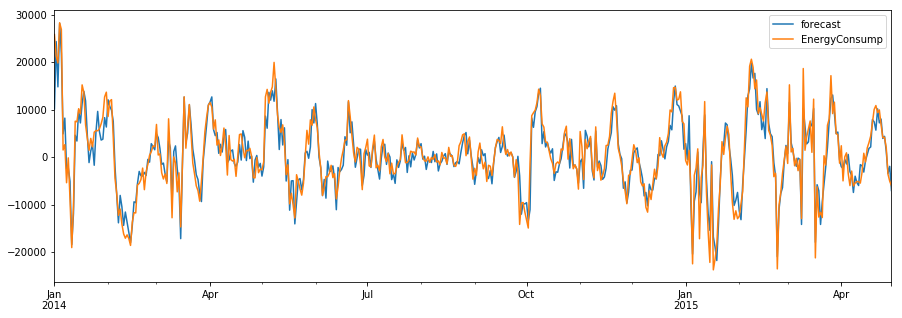

In [ ]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod107.plot_predict(start='2014-01-01', end='2015-04-30', ax=ax)
# legend = ax.legend(loc='upper left')

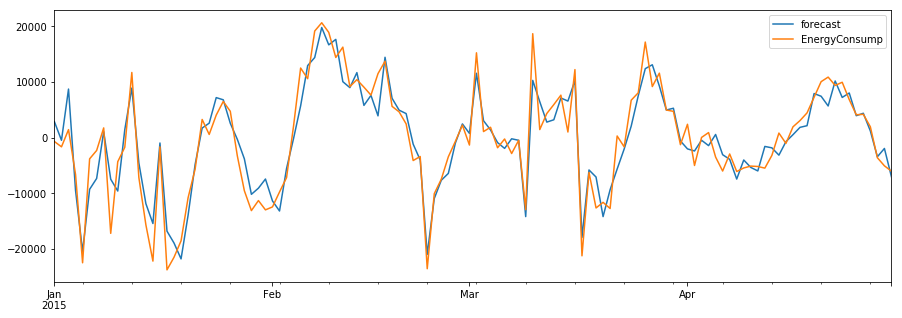

In [ ]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod107.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc = arima_mod107.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [ ]:
frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



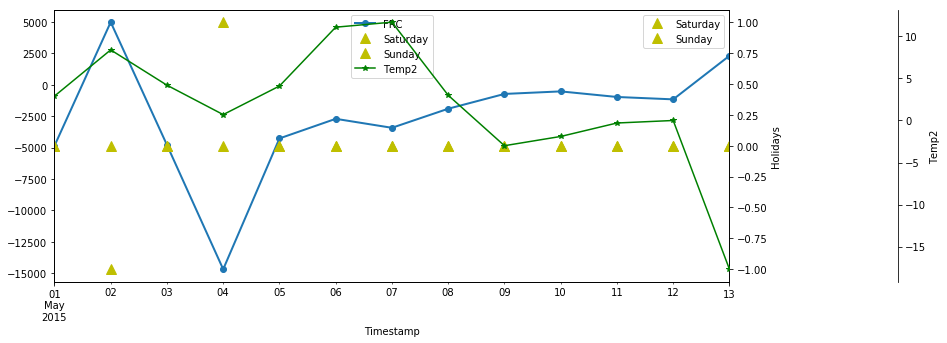

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


<h1 align="center">Forecasting with SARIMAX </h1>

** Question: ** 
 * What is the period of seasonality for this TS? Another way to say: what are specifications of ARIMA model for this TS:
    - ARIMA (2,0,7)x(1,0,1)_365
    - ARIMA (2,0,0)x(52,0,52)_7

We will apply p=7 to ts shift365_energy instead of p=365 to orifinal ts
    - use additional exogenious variable that correspond seasonality p=365

## A regression is built for the differences of TS and exogenious variables

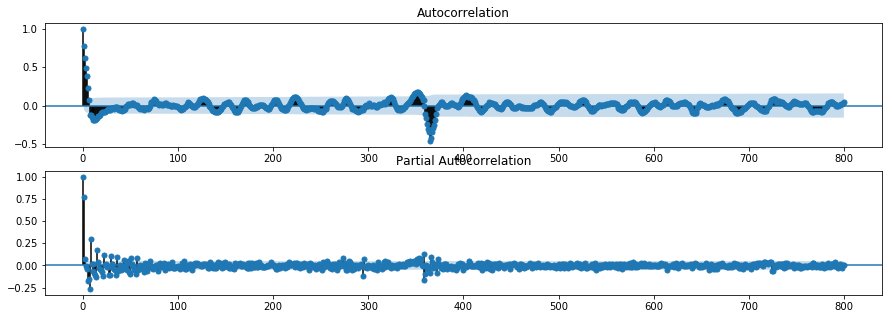

In [ ]:
# acf for stationary TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=800, ax=ax2)

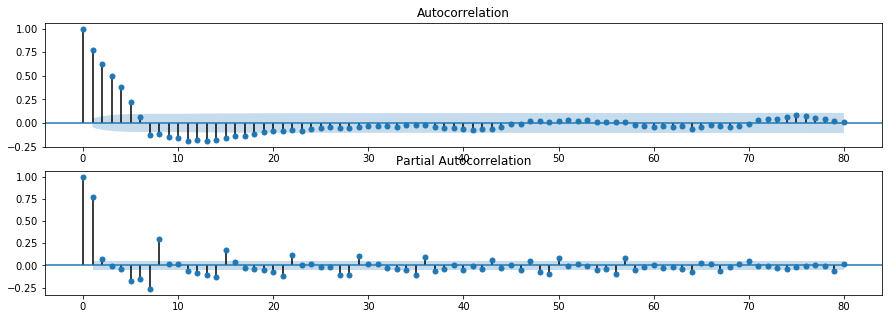

In [ ]:
# acf for stationary TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=80, ax=ax2)

** Question:**
* What are candidates for p and q?
    - candidates values for p - 1, 
    - candidates values for q - 0,
    - candidates values for P - 1, 2, 52
    - candidates values for Q - 1, 2, 52
* Apply SARIMA to shift365_energy TS: 
    - what is value for d, D?

In [ ]:
# apply regression for defferenced TS
exogs = shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']][shift365_energy.index<'2015-05-01']
extra_exogs = shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = shift365_energy[['EnergyConsump']][shift365_energy.index<'2015-05-01']

## 2) A suitable model  $ARMA(p1,q1)$ for residuals of regression  $z_t$  is selected 

In [ ]:
def my_func(ts, p,d,q,P,D,Q): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,7))
        results = mod.fit()
        return("sarimax_%i%i%i_%i%i%i: aic=%f, bic=%f, hqic=%f " % (p,d,q,P,D,Q, 
               results.aic, results.bic, results.hqic))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q))    

In [ ]:
from sklearn.grid_search import ParameterGrid
param_grid = {'p': [1], 'd' : [0],
             'q': [0], 'P' : [1,2],
             'D': [1], 'Q' : [1,2,52]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

sarimax_100_111: aic=30629.723649, bic=30651.186900, hqic=30637.698444 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_112: aic=30809.013701, bic=30835.842766, hqic=30818.982195 
sarimax_100_1152: can't fit model 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_211: aic=30631.587209, bic=30658.416273, hqic=30641.555703 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_212: aic=30810.265846, bic=30842.460723, hqic=30822.228038 
sarimax_100_2152: can't fit model 


In [ ]:
# Caution takes a lot of time
param_grid = {'p': [1], 'd' : [0],
             'q': [0], 'P' : [52],
             'D': [1], 'Q' : [1, 2,52]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

KeyboardInterrupt: 

## 3) Regression is rebuilt in supposition that the errors are described by model ARMA(p1,q1)

In [ ]:
sarimax_100_111 = sm.tsa.statespace.SARIMAX(ts, trend='n', 
                                            order=(1,0,0), seasonal_order=(1,1,1,7), exog=exogs).fit()

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



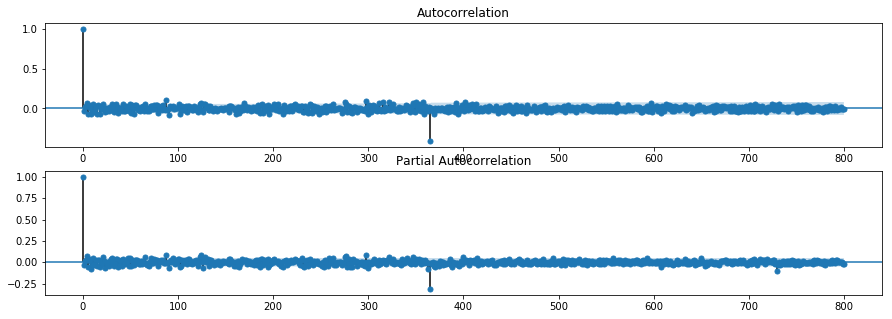

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=800, ax=ax2)

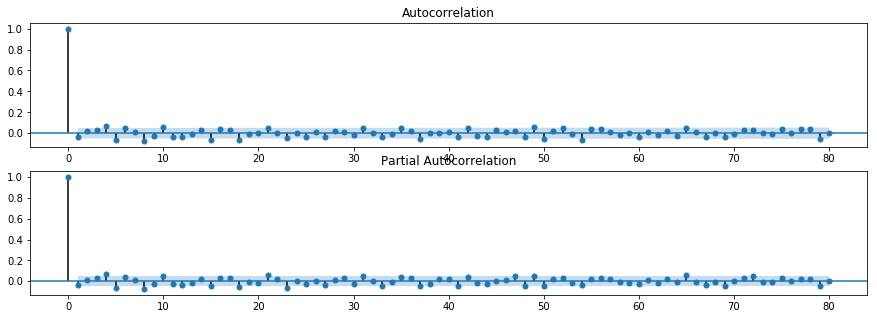

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax2)

* Let's fit model for q=5

In [ ]:
sarimax_105_111 = sm.tsa.statespace.SARIMAX(ts, trend='n', 
                                            order=(1,0,5), seasonal_order=(1,1,1,7), exog=exogs).fit()

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



ValueError: array must not contain infs or NaNs

* Is seems  there is no more lags to take into account (insead of lag 365 - you need to add in into exogenious) 
* Let's analyse resudials

## 4) Residuals $\varepsilon_t$  are analyzed.

### Stationarity

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(sarimax_100_111.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.377998, 
pvalue: 0.09 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* Residuals are stationary

### Autocorrelation test

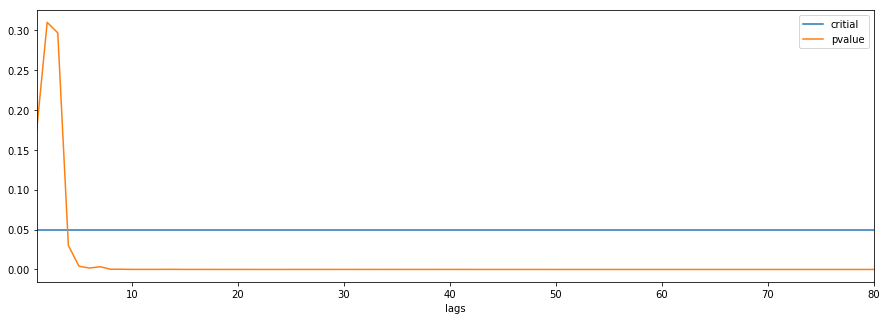

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(sarimax_100_111.resid.values, lags=80)[1], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

### Unbiasedness test

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(sarimax_100_111.resid.values)

2.0623514566086008

Residuals are not biased!

### Normality test

In [ ]:
stats.normaltest(sarimax_100_111.resid)

NormaltestResult(statistic=124.79153577361377, pvalue=7.9774173364255483e-28)

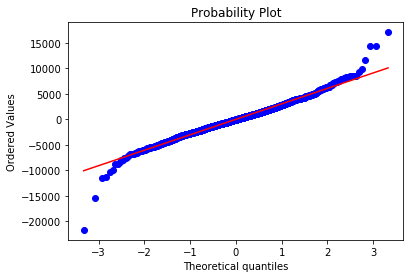

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(sarimax_100_111.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

In [ ]:
print(sarimax_100_111.summary())

                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1581
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 7)   Log Likelihood              -14868.708
Date:                           Mon, 25 Sep 2017   AIC                          29753.416
Time:                                   18:52:06   BIC                          29796.343
Sample:                               01-01-2011   HQIC                         29769.366
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        112.7736     30.711      3.672      0.000      52.582     172.965
Temp2       -218.8168     28.248     -7.746

## 5) Forecast is build for initial TS

### Retrospective forecast
The predict command is first applied here to get in-sample predictions. We use the full_results=True argument to allow us to calculate confidence intervals (the default output of predict is just the predicted values).
With no other arguments, predict returns the one-step-ahead in-sample predictions for the entire sample.

In [ ]:
predict = sarimax_100_111.get_prediction()
predict_ci = predict.conf_int() # confidence interval

One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

In [ ]:
#  Dynamic predictions
predict_dy = sarimax_100_111.get_prediction(dynamic='2014-01-01')
predict_dy_ci = predict_dy.conf_int() # confidence interval

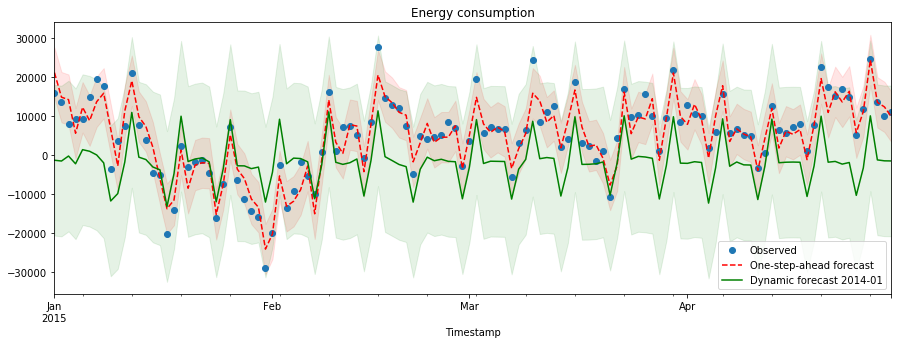

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(15,5))
npre = 4
ax.set(title='Energy consumption', xlabel='Date')

# Plot data points
ts.loc['2015-01-01':, 'EnergyConsump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean['2015-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2015-01-01':].plot(ax=ax, style='g', label='Dynamic forecast 2014-01')
ci = predict_dy_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [ ]:
# forecast of future values
frc =sarimax_100_111.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [ ]:
frc_arimax = extra_exogs.loc['2015-05-01':]
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



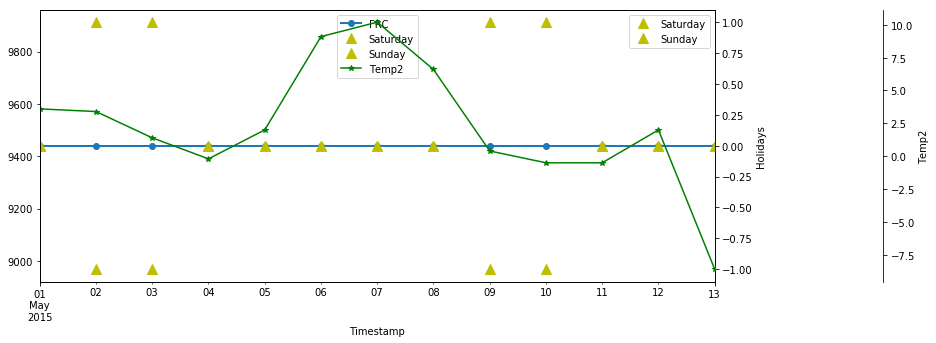

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


In [ ]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()
# Filter only Hub=Center and ZSP=FZSZOE27
energy_ts= energy_ts[(energy_ts['ZSP']=='FZSZOE27') & (energy_ts['Hub']=='Center')]
energy_ts.tail()

# See Year-Seasonality
energy_ts['EnergyConsump'].plot(figsize=(15,5))

# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_YearSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

# See Week easonality
energy_ts['EnergyConsump'].tail(186).plot(figsize=(15,5))

# re_energy = week_reshaping(energy_ts[['EnergyConsump']])
week_df = pd.DataFrame(index = energy_ts.index, columns = {'EnergyConsump', 'dayofweek', 'weekno'})
week_df['EnergyConsump'] = energy_ts['EnergyConsump']
week_df['dayofweek'] = week_df.index.dayofweek
week_df['weekno'] = week_df.index.week
week_df.head(10)

# See dependence on other varibales
fig, ax = plt.subplots(figsize=(15,5))
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

* **candidates values for q (according to ACF)** - 1, 9, 10 (don't look at 12 or greater: it's larger than period of seasonality)
* **candidates values for p (according to PACF)** - 1, 9 (don't look at 12 or greater: it's larger than period of seasonality)

In [ ]:
## Choosing best model accoridng to AIC criterion
arima_mod111 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,1)).fit()
print(arima_mod111.params)
print(arima_mod111.aic, arima_mod111.bic, arima_mod111.hqic)

const                 -0.000834
ar.L1.D.wage_boxcox   -0.539578
ma.L1.D.wage_boxcox    0.337118
dtype: float64
-991.4569907187226 -978.184510743 -986.088031868


In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod119 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,9)).fit()
print(arima_mod119.params)
print(arima_mod119.aic, arima_mod119.bic, arima_mod119.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod1110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,10)).fit()
print(arima_mod1110.params)
print(arima_mod1110.aic, arima_mod1110.bic, arima_mod1110.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod911 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,1)).fit()
print(arima_mod911.params)
print(arima_mod911.aic, arima_mod911.bic, arima_mod911.hqic)

const                 -0.000846
ar.L1.D.wage_boxcox   -0.909261
ar.L2.D.wage_boxcox   -0.066992
ar.L3.D.wage_boxcox    0.047736
ar.L4.D.wage_boxcox    0.039425
ar.L5.D.wage_boxcox    0.058467
ar.L6.D.wage_boxcox    0.068016
ar.L7.D.wage_boxcox    0.006379
ar.L8.D.wage_boxcox   -0.082354
ar.L9.D.wage_boxcox    0.073923
ma.L1.D.wage_boxcox    0.761500
dtype: float64
-988.2653500338749 -948.447910108 -972.158473483


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod919 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,9)).fit()
print(arima_mod919.params)
print(arima_mod919.aic, arima_mod919.bic, arima_mod919.hqic)

const                 -0.000976
ar.L1.D.wage_boxcox   -0.150403
ar.L2.D.wage_boxcox    0.519736
ar.L3.D.wage_boxcox    0.275666
ar.L4.D.wage_boxcox    0.275282
ar.L5.D.wage_boxcox   -0.024404
ar.L6.D.wage_boxcox   -0.182132
ar.L7.D.wage_boxcox   -0.598245
ar.L8.D.wage_boxcox   -0.227851
ar.L9.D.wage_boxcox    0.698578
ma.L1.D.wage_boxcox   -0.049985
ma.L2.D.wage_boxcox   -0.570083
ma.L3.D.wage_boxcox   -0.284679
ma.L4.D.wage_boxcox   -0.279555
ma.L5.D.wage_boxcox    0.281655
ma.L6.D.wage_boxcox    0.261406
ma.L7.D.wage_boxcox    0.597745
ma.L8.D.wage_boxcox   -0.007092
ma.L9.D.wage_boxcox   -0.943805
dtype: float64
-1004.279374514849 -937.916974638 -977.434580264


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod9110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,10)).fit()
print(arima_mod9110.params)
print(arima_mod9110.aic, arima_mod9110.bic, arima_mod9110.hqic)

const                  -0.000956
ar.L1.D.wage_boxcox    -0.332327
ar.L2.D.wage_boxcox     0.485708
ar.L3.D.wage_boxcox     0.249135
ar.L4.D.wage_boxcox     0.163675
ar.L5.D.wage_boxcox     0.128084
ar.L6.D.wage_boxcox    -0.110585
ar.L7.D.wage_boxcox    -0.600725
ar.L8.D.wage_boxcox    -0.135955
ar.L9.D.wage_boxcox     0.660917
ma.L1.D.wage_boxcox     0.111328
ma.L2.D.wage_boxcox    -0.665728
ma.L3.D.wage_boxcox    -0.238999
ma.L4.D.wage_boxcox    -0.057646
ma.L5.D.wage_boxcox     0.075386
ma.L6.D.wage_boxcox     0.261861
ma.L7.D.wage_boxcox     0.663913
ma.L8.D.wage_boxcox    -0.231085
ma.L9.D.wage_boxcox    -0.951199
ma.L10.D.wage_boxcox    0.034378
dtype: float64
-995.7245159431063 -926.043996072 -967.537481979


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



* According to AIC criterion arma_mod919 is best of this 6 models

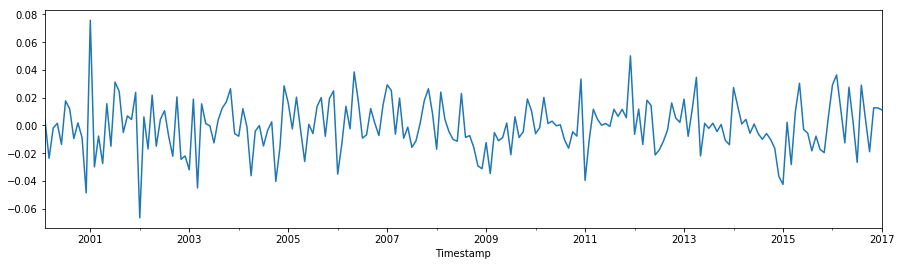

In [ ]:
# plot residuals
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = arima_mod919.resid.plot(ax=ax, figsize=(15,4));

Values of the TS are not correlated

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod919.resid.values)

2.0933382031995951

In [ ]:
stat = stats.wilcoxon(arima_mod919.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 10183.000000
pvalue: 0.75


Residuals are not biased!

# Conclusion
## Approach how to fit ARIMA

## Self-check questions
  1. How to define differencing order $d, D$ for a time series?
  2. What is autocorrelation function (ACF)?
  3. What does coefficient of correlation show?
  4. What is partial autocorrelation function (PACF)?  What does coefficient of partial correlation show?
  5. How do ACF and PACF help to choose $q, Q$ and $p, P$ of ARMA model?
   


**Materialsf**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model